Guassian augmentation

In [ ]:
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

#Set no aug

valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("gauAugExperiments")

stats = []
rate = 2

for val in xrange(1,6):
    train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True, augmentation = 1, aug_amount = val)
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['gauAugF'+str(layer)+str(val)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.053. Accuracy is 58.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.600. Accuracy is 81.41%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 384 pps. Validation speed 1740 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.518. Accuracy is 83.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.497. Accuracy is 85.12%
INFO:mlp.optimisers:Epoch 2: Took 8 seconds. Training speed 403 pps. Validation speed 1855 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.324. Accuracy is 91.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.458. Accuracy is 85.38%
INFO:mlp.optimisers:Epoch 3: Took 8 seconds. Training speed

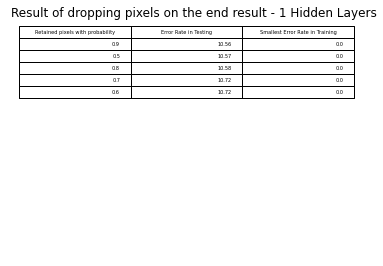

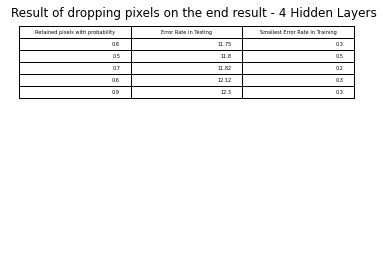

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [16]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("gauAugExperiments")
tracker = []
track2 = []


for val in xrange(1,6):
    #This should get the min train error
    second = shelve_p['gauAugF0'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([1.-(val/10.), 100-(100*shelve_p[('gauAugF0'+str(val))][2][1]),100.*(1.-second[0][1])])
    




tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing','Smallest Error Rate in Training' )
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(1,6):
    #This should get the min train error
    second = shelve_p['gauAugF1'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([1.-(val/10.), 100-(100*shelve_p[('gauAugF1'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing', 'Smallest Error Rate in Training')
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''





Rotation Augmentation

In [2]:
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

#Set no aug
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

for val in xrange(-8,9):
    train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True, augmentation = 2, aug_amount = val)
    
    #Build list once so we don't have to rebuild every time.
    for i in xrange(0,max_epochs):
        #In this order so start learning rate is added
        learningList.append(learning_rate)
        learning_rate -= decrement



    #Open file to save to
    shelve_r = shelve.open("rotAugExperiments", writeback = True)

    stats = []
    rate = 2

    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['rotAugF'+str(layer)+str(val)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.575. Accuracy is 9.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.409. Accuracy is 47.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.951. Accuracy is 70.16%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 323 pps. Validation speed 1956 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.823. Accuracy is 72.20%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.808. Accuracy is 72.76%
INFO:mlp.optimisers:Epoch 2: Took 8 seconds. Training speed 375 pps. Validation speed 2037 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.587. Accuracy is 82.20%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.707. Accuracy is 77.06%
INFO:mlp.optimisers:Epoch 3: Took 8 seconds. Training speed

error: cannot add item to database

In [20]:
 # import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("rotAugExperiments")
tracker = []
print shelve_p['rotAugF01']
for val in xrange(-10,11):
    tracker.append([1.-(val/10.), 100-(100*shelve_p[('rotAugF0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(-10,11):
    tracker.append([(1.-(val/10.)), 100-(100*shelve_p[('rotAugF1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()


'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''




KeyError: 'rotAugF01'

Dropout Augmentation

In [4]:
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

#Set no aug
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("augExperimentsFNR")

stats = []
rate = 2

for val in xrange(1,6):
    train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True, augmentation = 3, aug_amount = val)
    
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['dpAugF'+str(layer)+str(val)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.851. Accuracy is 61.50%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.594. Accuracy is 81.14%
INFO:mlp.optimisers:Epoch 1: Took 10 seconds. Training speed 328 pps. Validation speed 1506 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.502. Accuracy is 84.10%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.460. Accuracy is 86.49%
INFO:mlp.optimisers:Epoch 2: Took 9 seconds. Training speed 380 pps. Validation speed 1588 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.334. Accuracy is 89.50%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.666. Accuracy is 80.03%
INFO:mlp.optimisers:Epoch 3: Took 10 seconds. Training spe

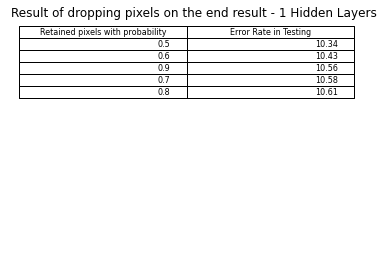

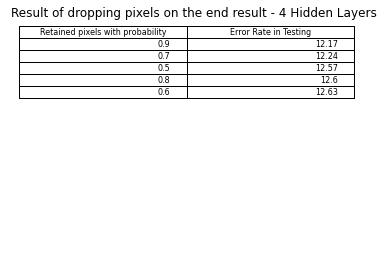

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [34]:
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("augExperimentsFNR")
tracker = []
for val in xrange(1,6):
    tracker.append([1.-(val/10.), 100-(100*shelve_p[('dpAugF0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(1,6):
    tracker.append([(1.-(val/10.)), 100-(100*shelve_p[('dpAugF1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Retained pixels with probability', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of dropping pixels on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()


'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''



Image Shift Augmentation

In [5]:
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

#Set no aug
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("augExperimentsFNR")

stats = []
rate = 2

for val in xrange(-5,6):
    train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True, augmentation = 4, aug_amount = val)
    

    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['siAugF'+str(layer)+str(val)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.611. Accuracy is 7.85%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.579. Accuracy is 45.85%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 1.016. Accuracy is 67.28%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 402 pps. Validation speed 1813 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.818. Accuracy is 74.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.722. Accuracy is 77.21%
INFO:mlp.optimisers:Epoch 2: Took 8 seconds. Training speed 413 pps. Validation speed 1820 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.583. Accuracy is 82.25%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.784. Accuracy is 74.24%
INFO:mlp.optimisers:Epoch 3: Took 8 seconds. Training speed

siAugF2-5


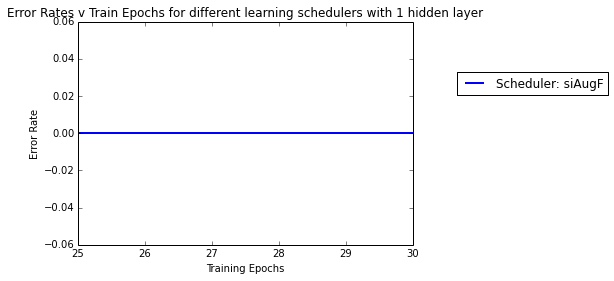

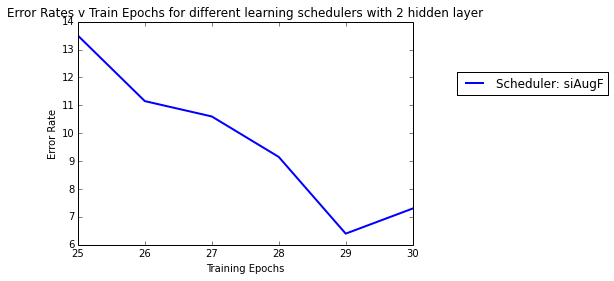

siAugF1-4


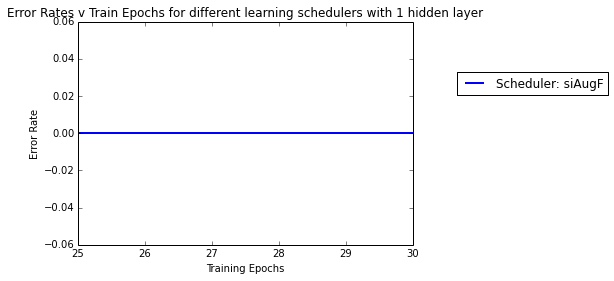

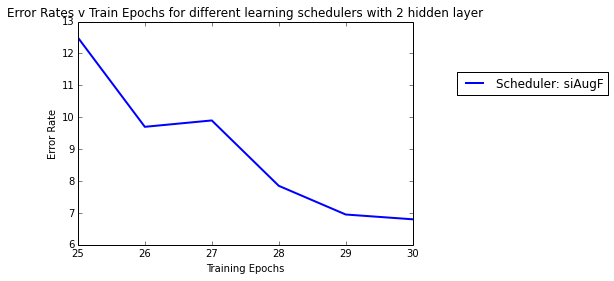

siAugF1-3


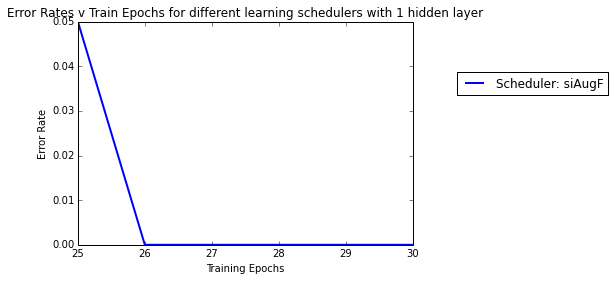

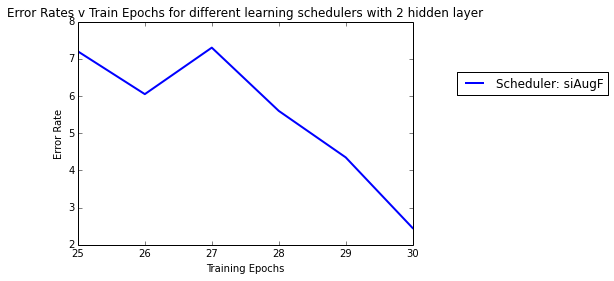

siAugF1-2


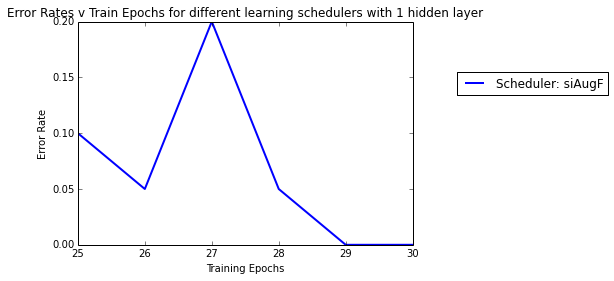

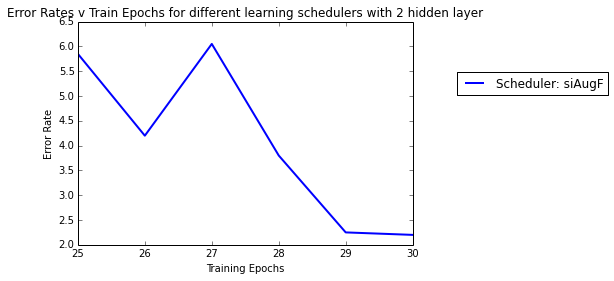

siAugF1-1


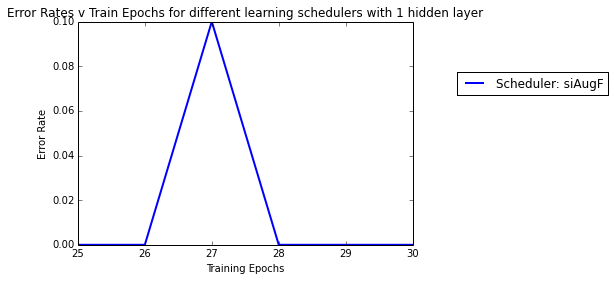

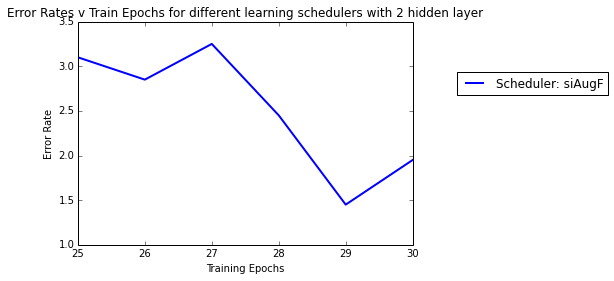

siAugF10


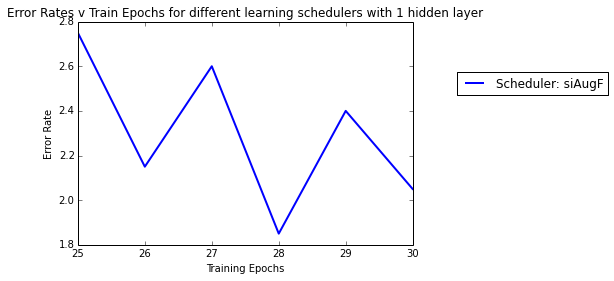

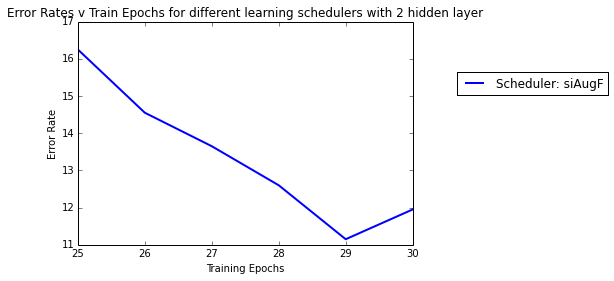

siAugF11


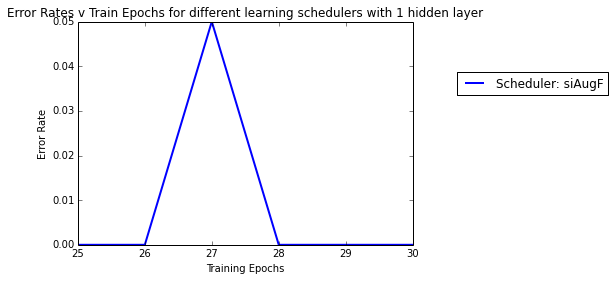

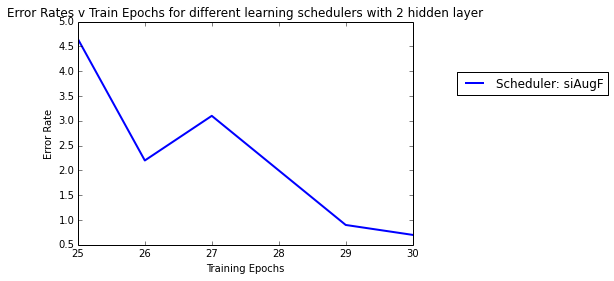

siAugF12


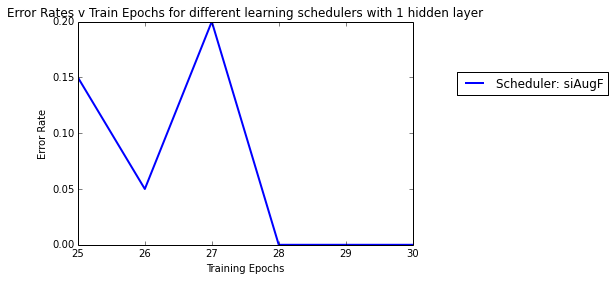

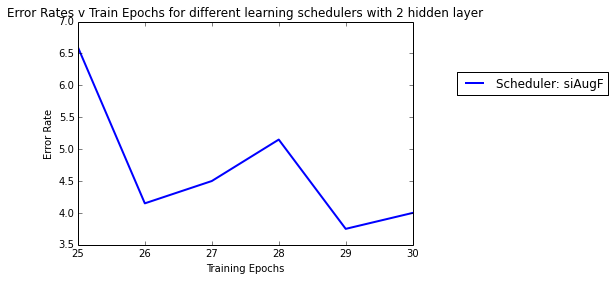

siAugF13


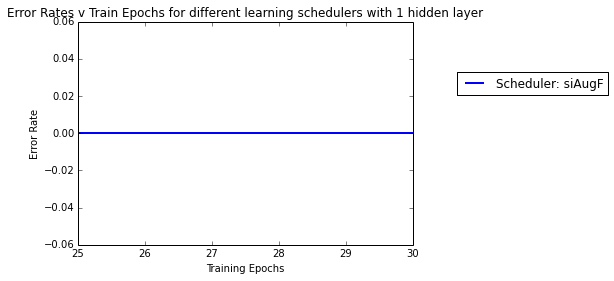

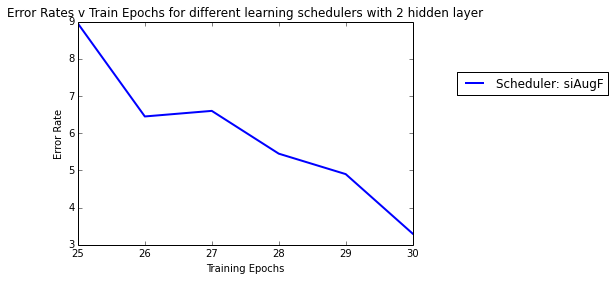

siAugF14


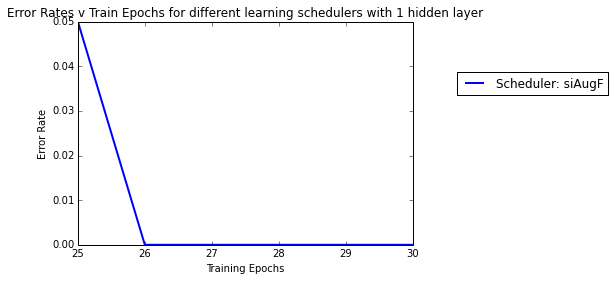

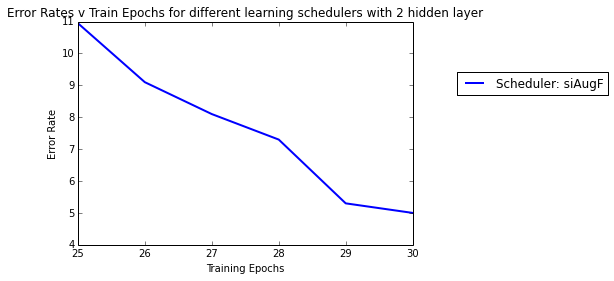

siAugF15


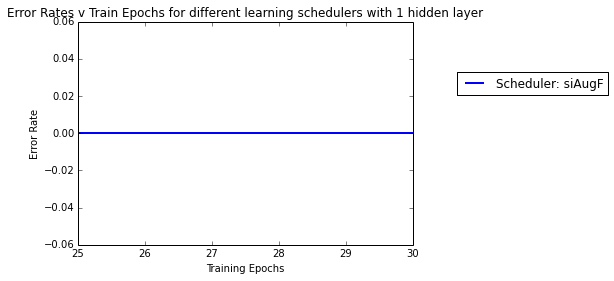

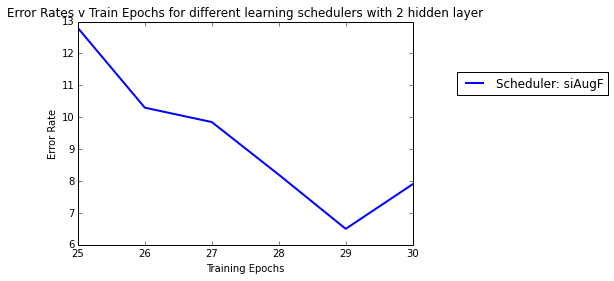

In [28]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("augExperimentsFNR")
x = range(0,31)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['siAugF']


for val in xrange(-5,6):
    
    print 'siAugF'+str(i)+str(val)
    for i in xrange(0,2):
        for idx,lists in enumerate(train_cont):
            train_error = []
            for inner_list in shelve_p[('siAugF'+str(i)+str(val))][0]:
                train_error.append(100-(inner_list[1]*100.))
            plt.plot(x[25:len(shelve_p[('siAugF'+str(i)+str(val))][0])], train_error[25:len(shelve_p[lists+str(i)+str(val)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


        plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
        plt.xlabel('Training Epochs')
        plt.legend
        plt.legend(bbox_to_anchor=(1.6, 0.8))
        plt.ylabel('Error Rate')
        plt.show()
        

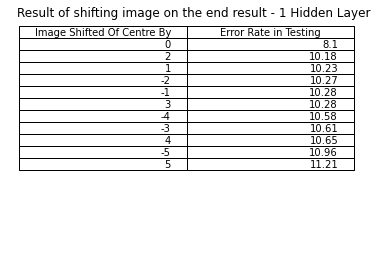

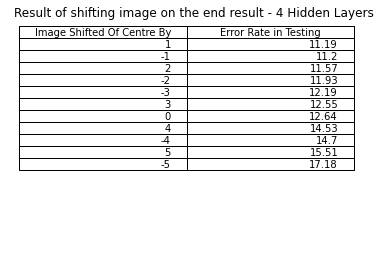

In [27]:
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("augExperimentsFNR")
tracker = []
for val in xrange(-5,6):
    tracker.append([val, 100-(100*shelve_p[('siAugF0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Image Shifted Of Centre By', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of shifting image on the end result - 1 Hidden Layer')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(-5,6):
    tracker.append([val, 100-(100*shelve_p[('siAugF1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Image Shifted Of Centre By', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of shifting image on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()


'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''
